# Seattle Housing Prices - Predictive Modeling

### Workflow:

1. Feature Engineering
    - (a) Create dummy variables
    - (b) Adjusting year_renovated column as categorical (yes or no) rather than by date
    - (c) Drop sqft_lot and sqft_lot15
    
    
2. Create Train_Test_Split


3. Run baseline model
    - print RMSE


4. Iterate on model:
    - (a) Remove outliers
    - (b) Remove collinear variables
    - (c) Log transformations
    - (d) Drop non-sig p-values
    - (e) Unit Vectorization (update x-columns to add in unit vectors composed of collinear variables)
    
 

### Plan so far...

#### Dependent Variable:

    - Price

#### Explanatory Variables:

    - Keep: ['bedrooms',
             'bathrooms',
             'sqft_living',
             'floors',
             'sqft_above',
             'sqft_basement',
             'sqft_living15',
             'view',
             'waterfront',
             'yr_built]
    
    - Drop: ['sqft_lot', 'sqft_lot15']
    
    - Create dummies: ['condition', 'zipcode', 'grade']
    
    - Convert to binary: ['yr_renovated']
    
    - Will have to think of a plan for latitude and longitude

In [102]:
# Thoughts for another time... so using city data instead of Zipcode dropped R2 and increased RMSE by about 20k.
# ... but it's better practice to drop the predictors by 46... 
# I suppose try it out this way for now instead of using zip - go by city

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

#### Import and drop columns:

In [7]:
house_data = pd.read_csv('house_data_cleaned.csv')
house_data.drop(['sqft_lot', 'sqft_lot15'], axis=1, inplace=True)
house_data.head()

,date,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15
0,10/13/2014,221900.0,3,1.00,1180,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340
1,12/9/2014,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690
2,2/25/2015,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720
3,12/9/2014,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360
4,2/18/2015,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800


In [9]:
house_data['month'] = house_data.date.apply(lambda x: x.split('/'))
house_data['month'] = house_data.month.apply(lambda x: x[0:1])
house_data['month'] = house_data.month.apply(lambda x: str(x))
house_data['month'] = house_data.month.apply(lambda x: x.strip("[]"))
house_data['month'] = house_data.month.apply(lambda x: x.strip("''"))
house_data.month = house_data['month'].astype(int)
house_data.head()

,date,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,month
0,10/13/2014,221900.0,3,1.00,1180,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,10
1,12/9/2014,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,12
2,2/25/2015,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,2
3,12/9/2014,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,12
4,2/18/2015,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,2


#### Create dummy variables:

In [3]:
def zco(x):
    city = search.by_zipcode(x).city 
    return city if city else x  # if city is None for certain zipcodes, take advantage of the truthiness of None

In [4]:
house_data['city'] = house_data['zipcode'].apply(zco)

In [5]:
# Drop first variable so they do not reference one another
# grade_dum = pd.get_dummies(house_data['grade'], prefix='grade_', drop_first=True)
# view_dum = pd.get_dummies(house_data['view'], prefix='view_', drop_first=True)
# zipcode_dum = pd.get_dummies(house_data['zipcode'], prefix='zipcode_', drop_first=True)
city_dum = pd.get_dummies(house_data['city'], prefix='city', drop_first=True)
# zipcode_dum.head()

In [6]:
# Now to merge dummy columns onto our dataframe
upHouse_data = pd.concat([house_data, city_dum], axis=1)
upHouse_data.drop(columns=['zipcode', 'city'], inplace=True)
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               21597 non-null  float64
 1   bedrooms            21597 non-null  int64  
 2   bathrooms           21597 non-null  float64
 3   sqft_living         21597 non-null  int64  
 4   floors              21597 non-null  float64
 5   waterfront          21597 non-null  float64
 6   view                21597 non-null  float64
 7   condition           21597 non-null  int64  
 8   grade               21597 non-null  int64  
 9   sqft_above          21597 non-null  int64  
 10  sqft_basement       21597 non-null  float64
 11  yr_built            21597 non-null  int64  
 12  yr_renovated        21597 non-null  float64
 13  lat                 21597 non-null  float64
 14  long                21597 non-null  float64
 15  sqft_living15       21597 non-null  int64  
 16  city

In [7]:
# Create a binary renovated column to determine whether the home was renovated or not
# Since the year renovated is not actionable unless we specialize in selling renovated homes from specific years
# but this way we can determine whether we should focus on renovations or not
upHouse_data['yr_renovated'] = upHouse_data.yr_renovated.apply(lambda x: 1 if x > 0 else 0)
upHouse_data.rename(columns = {"yr_renovated":"renovated"}, inplace=True)

In [8]:
# Create a new df that only includes the variable pairs that are correlated
# These variables are our feature variables only
# We'll start with a cutoff of 0.5 to see which have a moderate and above correlation - we may change during modeling
coral = upHouse_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

coral['pairs'] = list(zip(coral.level_0, coral.level_1))

coral.set_index(['pairs'], inplace = True)

coral.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
coral.columns = ['cc']

coral.drop_duplicates(inplace=True)

coral[(coral.cc>.7) & (coral.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(bathrooms, sqft_living)",0.755758
"(sqft_above, sqft_living15)",0.731767
"(sqft_living15, grade)",0.713867
"(city_Seattle, long)",0.709844
"(sqft_living, price)",0.701917


In [9]:
# drop squarefoot above. Maybe interaction with squarefoot living and living15
upHouse_data.drop('sqft_above', axis=1, inplace=True)

In [10]:
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               21597 non-null  float64
 1   bedrooms            21597 non-null  int64  
 2   bathrooms           21597 non-null  float64
 3   sqft_living         21597 non-null  int64  
 4   floors              21597 non-null  float64
 5   waterfront          21597 non-null  float64
 6   view                21597 non-null  float64
 7   condition           21597 non-null  int64  
 8   grade               21597 non-null  int64  
 9   sqft_basement       21597 non-null  float64
 10  yr_built            21597 non-null  int64  
 11  renovated           21597 non-null  int64  
 12  lat                 21597 non-null  float64
 13  long                21597 non-null  float64
 14  sqft_living15       21597 non-null  int64  
 15  city_Bellevue       21597 non-null  uint8  
 16  city

In [10]:
list_cols = list(upHouse_data.columns)

NameError: name 'upHouse_data' is not defined

### Scaling

In [ ]:
#Separate data into categorical and continuous groups. 
cat_data = data[['WaterFront', 'Bellevue', 'Federal Way',
                 'Kent', 'Renton', 'Seattle', 'Renovated']]

con_data = data.drop(['WaterFront', 'Bellevue', 
                      'Federal Way', 'Kent', 'Renton', 
                      'Seattle', 'Renovated'], 
                     axis=1)

In [ ]:
def scale(col):
    return(con_data[col]-
           con_data[col].mean())/con_data[col].std()

In [ ]:
scaled_data = pd.DataFrame([])
for col in con_data.columns:
    scaled_data[col] = scale(col)

In [ ]:
#Join continuous and categorical data. 
model_data = scaled_data.join(cat_data, how='outer')
model_data.describe()

### Now Train-Test-Split

... in preparation for our baseline model

In [11]:
# Your code here - Define the target and predictors
outcome = 'price'
feat_cols = list(upHouse_data.columns)
feat_cols.remove(outcome)

In [12]:
X = upHouse_data[feat_cols]
y = upHouse_data['price']

In [13]:
# Initial test-size of 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)
print(len(X_train), len(y_test))
X_train.head()

15117 6480


,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,yr_built,...,city_Medina,city_Mercer Island,city_North Bend,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville
4900,3,1.00,1200,1.0,0.0,0.0,4,7,0.0,1969,...,0,0,0,0,0,0,0,0,0,0
19664,3,2.50,1920,1.0,0.0,0.0,3,8,0.0,2014,...,0,0,0,0,0,0,0,0,0,0
13949,3,1.75,1590,1.5,0.0,0.0,4,6,0.0,1926,...,0,0,0,0,0,0,0,0,0,0
15272,4,4.00,2530,3.0,0.0,2.0,3,9,430.0,2013,...,0,0,0,0,0,0,1,0,0,0
14411,3,2.50,2010,2.0,0.0,0.0,3,8,620.0,2014,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

### Vanilla Model

#### Side Note: Model Function

In [15]:
# I don't need those predictors/formulas
def training_model(predictor_cols, outcome, y_train, X_train):
    predictors = '+'.join(predictor_cols)
    formula = outcome + '~' + predictors
    model_vanilla = sm.OLS(y_train, X_train).fit()
    return model_vanilla.summary()

In [16]:
training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:55:13   Log-Likelihood:            -2.0450e+05
No. Observations:               15117   AIC:                         4.091e+05
Df Residuals:                   15079   BIC:                         4.094e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -7.214e+07   4.41e+06    -16.345      0.000   -8.08e+07   -6.35e+07
bedrooms            -3.17e+04   2017.750    -15.710      0.000   -3.57e+04   -2.77e+04
bathrooms           3.138e+04   3516.197      8.925      0.000    2.45e+04    3.83e+04
sqft_living          175.5530      3.949     44.456      0.000     167.813     183.293
floors              1.382e+04   3982.938      3.470      0.001    6015.382    2.16e+04
waterfront          6.472e+05   1.93e+04     33.552      0.000    6.09e+05    6.85e+05
view                4.819e+04   2297.781     20.971      0.000    4.37e+04    5.27e+04
condition           2.071e+04   2561.172      8.087      0.000    1.57e+04    2.57e+04
grade               8.448e+04   2383.436     35.444      0.000    7.98e+04    8.92e+04
sqft_basement        -34.4598      4.706     -7.322      0.000     -43.685     -25.235
yr_built           -2045.2144     81.023    -25.242      0.000   -2204.029   -1886.400
renovated           2.243e+04   8592.936      2.611      0.009    5591.178    3.93e+04
lat                 5.836e+05   2.32e+04     25.193      0.000    5.38e+05    6.29e+05
long               -3.913e+05   3.57e+04    -10.971      0.000   -4.61e+05   -3.21e+05
sqft_living15         20.4984      3.841      5.336      0.000      12.969      28.028
city_Bellevue       2.198e+05    1.2e+04     18.309      0.000    1.96e+05    2.43e+05
city_Black Diamond  1.401e+05   2.42e+04      5.784      0.000    9.26e+04    1.88e+05
city_Bothell       -1.481e+05   1.99e+04     -7.442      0.000   -1.87e+05   -1.09e+05
city_Carnation      5.971e+04   2.69e+04      2.217      0.027    6908.071    1.13e+05
city_Duvall        -4.879e+04   2.28e+04     -2.138      0.033   -9.35e+04   -4061.842
city_Enumclaw       1.723e+05   1.84e+04      9.377      0.000    1.36e+05    2.08e+05
city_Fall City      1.556e+05   2.81e+04      5.540      0.000    1.01e+05    2.11e+05
city_Federal Way   -7.927e+04   1.16e+04     -6.816      0.000   -1.02e+05   -5.65e+04
city_Issaquah       1.026e+05   1.42e+04      7.215      0.000    7.47e+04    1.31e+05
city_Kenmore       -1.633e+05    1.8e+04     -9.068      0.000   -1.99e+05   -1.28e+05
city_Kent          -5520.2711   9986.718     -0.553      0.580   -2.51e+04    1.41e+04
city_Kirkland         4.1e+04   1.37e+04      2.986      0.003    1.41e+04    6.79e+04
city_Maple Valley   7.379e+04   1.36e+04      5.438      0.000    4.72e+04       1e+05
city_Medina          9.32e+05   3.26e+04     28.572      0.000    8.68e+05    9.96e+05
city_Mercer Island   3.37e+05   1.64e+04     20.608      0.000    3.05e+05    3.69e+05
city_North Bend      1.82e+05    2.4e+04      7.571      0.000    1.35e+05    2.29e+05
city_Redmond        3.829e+04   1.46e+04      2.631      0.009    9758.506    6.68e+04
city_Renton        -1.108e+04   1.02e+

In [17]:
# We see a very high R-squared and large standard errors, likely because of collinearity
# During our EDA, we noted there were several collinear variable pairs to be addressed

With our QQ plot for the vanilla model above, we can see that the graph is not normal with heavy skew on both low and high ends. The upper end has a greater skew showing there are likely a large number of outliers on this end.

We may want to consider reducing outliers at 2 standard deviations (95%) to have the most accurate predictions. The only reason we wouldn't is if we wanted to focus on selling either cheap or luxury homes. If we were doing so, we would have to narrow our data set to these alone.

In [18]:
model_vanilla = sm.OLS(y_train, X_train).fit()

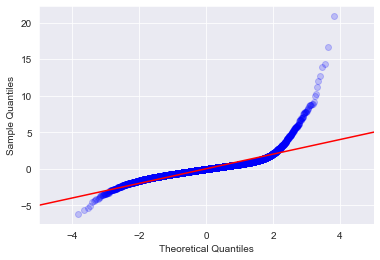

In [19]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_vanilla.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [20]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_vanilla.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_vanilla.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))


Train RMSE: 181471.70886246453 
 Test RMSE: 190645.07025761876
Percent change:  5.055


In [21]:
# Our test model is actually not far off, especially for the vanilla model.
# That being said, RMSE seems high. I think we can bring this down...
# especially by removing outliers and collinearity

### Model 2: Removing Outliers

In [22]:
# Going to remove outliers based on 2 standard deviations (95%)
# This is because our business focus is not on the most expensive or the cheapest homes.
# So in order to improve our model's prediction for relevant prices, we'll narrow our scope
# Down the line, I'd like to look at zipcodes and schools/bus stop data to see if that correlates with price
# If so, maybe we focus on those homes.
# Otherwise, let's see how renovations predicts pricing

Based on the results below for standard deviation of pricing, it would be inaccurate to filter our training and testing sets based on their own respective standard deviation since they will differ.

Therefore, to maintain consistency without training the original training set, we will filter both training and testing data based on 2 standard deviations from the mean from the overall dataset. This is effectively the same results as removing the pricing outliers before train_test_split.

In [23]:
# Here is our code for filtering the training set based on 2 std from full dataset
# We can see the before and after to verify that outliers have been trimmed
mean_price = np.mean(upHouse_data.price, axis=0)
sd_price = np.std(upHouse_data.price, axis=0)

final_y_train_list = [y for y in y_train if (y > mean_price - 2 * sd_price)]
final_y_train_list = [y for y in final_y_train_list if (y < mean_price + 2 * sd_price)]
y_train_2std = pd.Series(final_y_train_list)

#### Comparison of y_train set before and after filtering for 2 standard deviations for price from the full dataset:

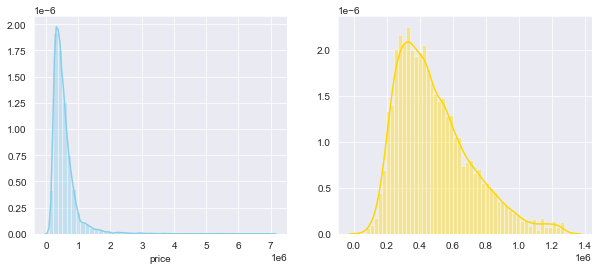

In [24]:
f, axes = plt.subplots(1, 2, figsize=(10,4));
sns.distplot(y_train, color="skyblue", ax=axes[0])
sns.distplot(y_train_2std, color="gold", ax=axes[1]);

In [25]:
# filter the data frame to remove the values exceeding 2 standard deviations based on y (our price)
# Practicing on dataset. Will then apply to our y_train/y_test data 
upHouse_data_2std = upHouse_data[np.abs(stats.zscore(upHouse_data.price)) < 2]

# How many rows were removed & how many rows are left
print(len(upHouse_data.index.difference(upHouse_data_2std.index)))
len(upHouse_data_2std)

841


20756

In [26]:
X = upHouse_data_2std[feat_cols]
y = upHouse_data_2std['price']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

In [28]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [29]:
training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:55:15   Log-Likelihood:            -1.8934e+05
No. Observations:               14529   AIC:                         3.788e+05
Df Residuals:                   14491   BIC:                         3.791e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5.255e+07   2.78e+06    -18.906      0.000    -5.8e+07   -4.71e+07
bedrooms           -1.084e+04   1281.277     -8.459      0.000   -1.33e+04   -8326.498
bathrooms           2.311e+04   2245.168     10.291      0.000    1.87e+04    2.75e+04
sqft_living           93.3585      2.675     34.897      0.000      88.115      98.602
floors              2.685e+04   2518.774     10.658      0.000    2.19e+04    3.18e+04
waterfront          1.448e+05   1.82e+04      7.958      0.000    1.09e+05     1.8e+05
view                3.262e+04   1542.761     21.141      0.000    2.96e+04    3.56e+04
condition           2.306e+04   1596.066     14.450      0.000    1.99e+04    2.62e+04
grade               6.476e+04   1519.854     42.608      0.000    6.18e+04    6.77e+04
sqft_basement        -16.7974      3.103     -5.413      0.000     -22.880     -10.715
yr_built           -1524.7416     51.046    -29.870      0.000   -1624.798   -1424.685
renovated           2.919e+04   5622.858      5.192      0.000    1.82e+04    4.02e+04
lat                 5.063e+05   1.43e+04     35.449      0.000    4.78e+05    5.34e+05
long                -2.54e+05   2.24e+04    -11.338      0.000   -2.98e+05    -2.1e+05
sqft_living15         44.2988      2.538     17.451      0.000      39.323      49.274
city_Bellevue       1.694e+05   7418.118     22.831      0.000    1.55e+05    1.84e+05
city_Black Diamond  1.455e+05   1.43e+04     10.151      0.000    1.17e+05    1.74e+05
city_Bothell       -9.432e+04   1.23e+04     -7.664      0.000   -1.18e+05   -7.02e+04
city_Carnation      3.806e+04   1.62e+04      2.350      0.019    6316.875    6.98e+04
city_Duvall        -3.937e+04   1.36e+04     -2.903      0.004    -6.6e+04   -1.28e+04
city_Enumclaw       1.216e+05   1.09e+04     11.119      0.000       1e+05    1.43e+05
city_Fall City      1.159e+05   1.78e+04      6.497      0.000     8.1e+04    1.51e+05
city_Federal Way   -5.322e+04   7070.909     -7.527      0.000   -6.71e+04   -3.94e+04
city_Issaquah       1.234e+05   8728.199     14.142      0.000    1.06e+05    1.41e+05
city_Kenmore       -1.078e+05   1.09e+04     -9.873      0.000   -1.29e+05   -8.64e+04
city_Kent          -9060.0853   6055.580     -1.496      0.135   -2.09e+04    2809.625
city_Kirkland        4.75e+04   8418.070      5.643      0.000     3.1e+04     6.4e+04
city_Maple Valley   6.038e+04   8290.750      7.283      0.000    4.41e+04    7.66e+04
city_Medina         4.732e+05   3.97e+04     11.918      0.000    3.95e+05    5.51e+05
city_Mercer Island  2.754e+05   1.12e+04     24.587      0.000    2.53e+05    2.97e+05
city_North Bend     1.535e+05   1.49e+04     10.310      0.000    1.24e+05    1.83e+05
city_Redmond        8.923e+04   8856.497     10.075      0.000    7.19e+04    1.07e+05
city_Renton         3453.0436   6199.8

In [30]:
model_outliers = sm.OLS(y_train, X_train).fit()

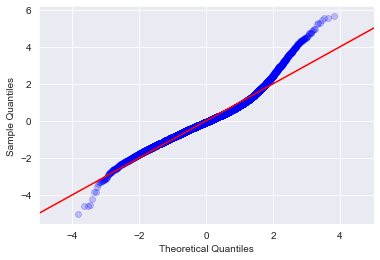

In [31]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_outliers.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [32]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_outliers.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_outliers.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((90380.9479527678-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 110551.160135469 
 Test RMSE: 110795.03388928871
Percent change:  0.221
Percent change (Base Model vs. Model-Outliers Removed):  -42.753


Adjusted R-squared improved by .003 to .836

RMSE decreased by 42.753% showing significant error reduction

### Model: Further Price Narrowing

In [33]:
upHouse_data_prim = upHouse_data_2std[upHouse_data_2std['price'] <= 790000]

In [34]:
X = upHouse_data_prim[feat_cols]
y = upHouse_data_prim['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     858.8
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:55:15   Log-Likelihood:            -1.6557e+05
No. Observations:               12958   AIC:                         3.312e+05
Df Residuals:                   12920   BIC:                         3.315e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.449e+07    2.3e+06    -19.358      0.000    -4.9e+07      -4e+07
bedrooms           -1.031e+04   1150.999     -8.953      0.000   -1.26e+04   -8049.234
bathrooms           2.161e+04   1900.832     11.371      0.000    1.79e+04    2.53e+04
sqft_living           70.9515      2.423     29.279      0.000      66.202      75.702
floors              2.183e+04   2097.367     10.409      0.000    1.77e+04    2.59e+04
waterfront          9.014e+04   1.83e+04      4.924      0.000    5.43e+04    1.26e+05
view                2.249e+04   1474.558     15.255      0.000    1.96e+04    2.54e+04
condition           2.094e+04   1298.610     16.125      0.000    1.84e+04    2.35e+04
grade                 4.9e+04   1304.761     37.554      0.000    4.64e+04    5.16e+04
sqft_basement         -8.7623      2.731     -3.209      0.001     -14.115      -3.410
yr_built           -1096.0593     43.376    -25.269      0.000   -1181.083   -1011.035
renovated           9259.5551   4879.451      1.898      0.058    -304.889    1.88e+04
lat                 4.508e+05   1.14e+04     39.475      0.000    4.28e+05    4.73e+05
long                -2.04e+05   1.86e+04    -10.996      0.000    -2.4e+05   -1.68e+05
sqft_living15         39.0590      2.242     17.425      0.000      34.665      43.453
city_Bellevue       1.334e+05   6257.900     21.309      0.000    1.21e+05    1.46e+05
city_Black Diamond   1.43e+05   1.18e+04     12.086      0.000     1.2e+05    1.66e+05
city_Bothell       -5.876e+04   9810.609     -5.989      0.000    -7.8e+04   -3.95e+04
city_Carnation      4.214e+04   1.28e+04      3.298      0.001    1.71e+04    6.72e+04
city_Duvall        -2.972e+04    1.1e+04     -2.702      0.007   -5.13e+04   -8159.092
city_Enumclaw       1.107e+05   8664.785     12.780      0.000    9.38e+04    1.28e+05
city_Fall City      1.009e+05   1.49e+04      6.784      0.000    7.18e+04     1.3e+05
city_Federal Way   -4.604e+04   5487.648     -8.390      0.000   -5.68e+04   -3.53e+04
city_Issaquah       1.312e+05   7049.200     18.614      0.000    1.17e+05    1.45e+05
city_Kenmore       -7.597e+04   8636.836     -8.796      0.000   -9.29e+04    -5.9e+04
city_Kent          -1.202e+04   4660.857     -2.579      0.010   -2.12e+04   -2886.626
city_Kirkland        3.43e+04   6846.425      5.010      0.000    2.09e+04    4.77e+04
city_Maple Valley    5.66e+04   6519.523      8.682      0.000    4.38e+04    6.94e+04
city_Medina         4.028e+05    8.6e+04      4.686      0.000    2.34e+05    5.71e+05
city_Mercer Island  2.221e+05   1.31e+04     16.925      0.000    1.96e+05    2.48e+05
city_North Bend     1.311e+05   1.18e+04     11.131      0.000    1.08e+05    1.54e+05
city_Redmond        9.989e+04   7180.607     13.912      0.000    8.58e+04    1.14e+05
city_Renton         5742.1077   4812.6

In [35]:
model_prim = sm.OLS(y_train, X_train).fit()

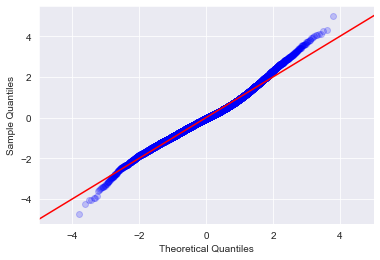

In [36]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_prim.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [37]:
# QQ Plot has heavy tails especially on the high-end. 
# Further trimming may be warranted. But first, let's work with what we got.

In [38]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_prim.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_prim.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 85664.9633437113 
 Test RMSE: 87449.62358731775
Percent change:  2.083
Percent change (Base Model vs. Model-Outliers Removed):  -44.609


Woah... that's better than I thought it would be. Slight decrease in R-squared but reduced error and close predictions between train and test sets.

Improved normalcy shown in QQ plot with further price trimming.

In [39]:
# Create a new df that only includes the variable pairs that are correlated
# These variables are our feature variables only
# We'll start with a cutoff of 0.5 to see which have a moderate and above correlation - we may change during modeling
coral = upHouse_data_prim.corr().abs().stack().reset_index().sort_values(0, ascending=False)

coral['pairs'] = list(zip(coral.level_0, coral.level_1))

coral.set_index(['pairs'], inplace = True)

coral.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
coral.columns = ['cc']

coral.drop_duplicates(inplace=True)

coral[(coral.cc>.7) & (coral.cc<1)]

,cc
pairs,
"(sqft_living15, sqft_living)",0.707864


### Model: Interactions

In [40]:
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%run -i "functions/interactions.py"
%run -i "functions/plot_interactions.py"


Testing 703 combinations.

R^2 including interaction of long and city_Seattle: 0.718


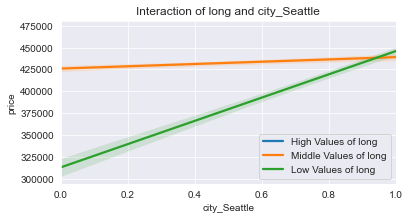

*********************

R^2 including interaction of lat and city_Kirkland: 0.717


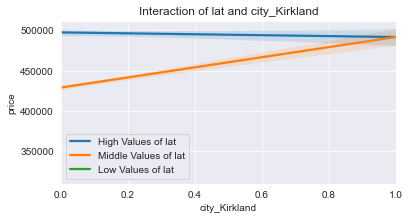

*********************

R^2 including interaction of yr_built and long: 0.715


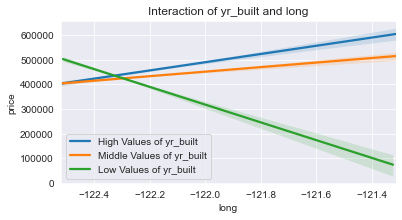

*********************

R^2 including interaction of grade and city_Seattle: 0.715


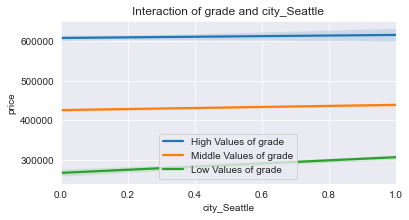

*********************

R^2 including interaction of yr_built and city_Seattle: 0.714


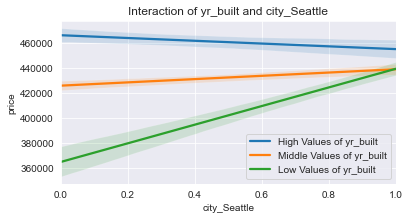

*********************

R^2 including interaction of sqft_living15 and city_Federal Way: 0.713


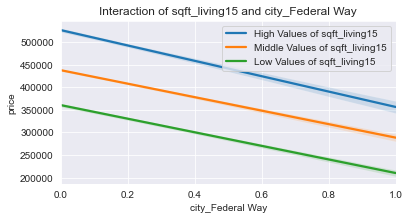

*********************

R^2 including interaction of sqft_living and sqft_basement: 0.713


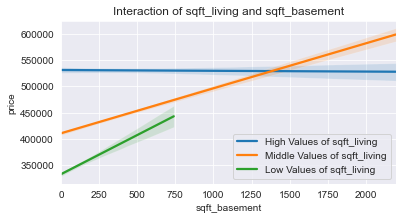

*********************

R^2 including interaction of sqft_living and lat: 0.713


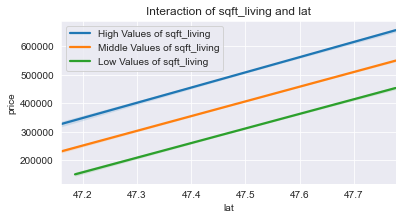

*********************

R^2 including interaction of sqft_living and city_Federal Way: 0.713


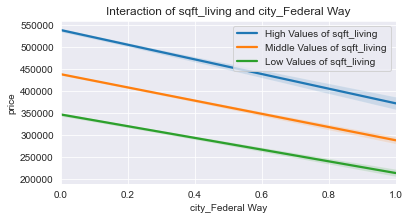

*********************

R^2 including interaction of long and city_Kent: 0.713


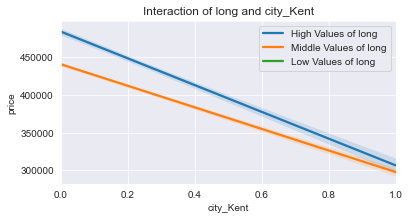

*********************

R^2 including interaction of lat and sqft_living15: 0.713


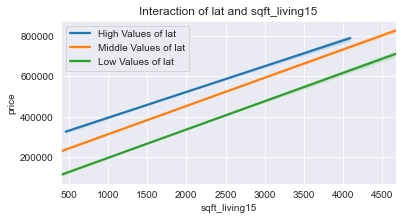

*********************

R^2 including interaction of grade and lat: 0.713


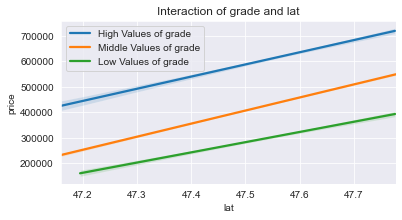

*********************

R^2 including interaction of grade and city_Federal Way: 0.713


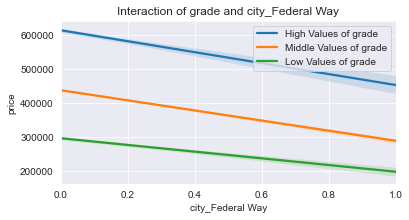

*********************

R^2 including interaction of sqft_living and view: 0.712


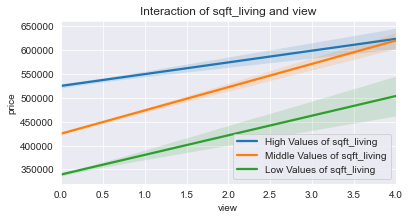

*********************

R^2 including interaction of sqft_living and sqft_living15: 0.712


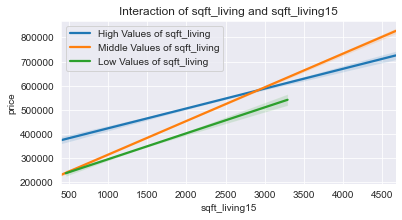

*********************



In [41]:
interactions = find_interactions(15, model_prim, X_train)

In [42]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('yr_built', 'long'),
 ('grade', 'city_Seattle'),
 ('yr_built', 'city_Seattle'),
 ('sqft_living15', 'city_Federal Way'),
 ('sqft_living', 'sqft_basement'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'city_Federal Way'),
 ('long', 'city_Kent'),
 ('lat', 'sqft_living15'),
 ('grade', 'lat'),
 ('grade', 'city_Federal Way'),
 ('sqft_living', 'view'),
 ('sqft_living', 'sqft_living15')]

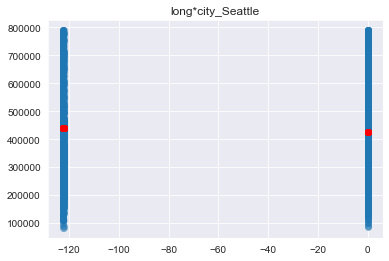

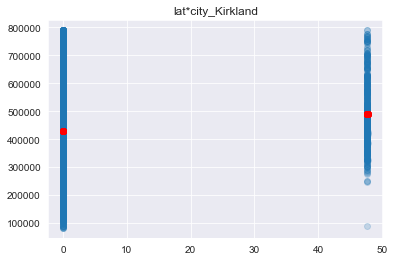

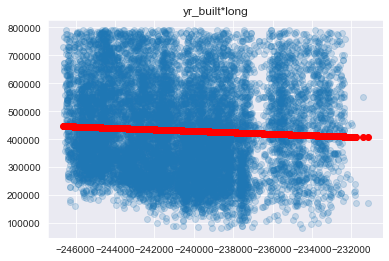

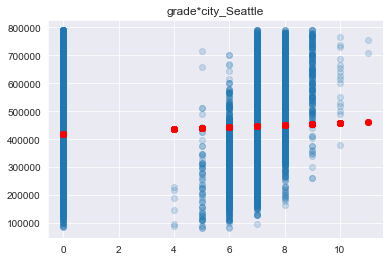

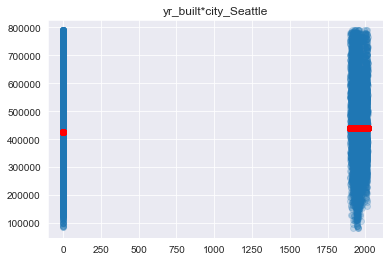

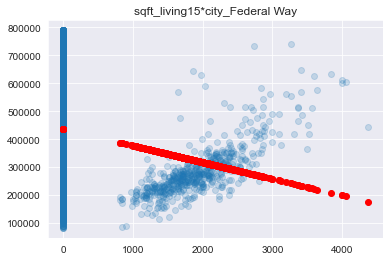

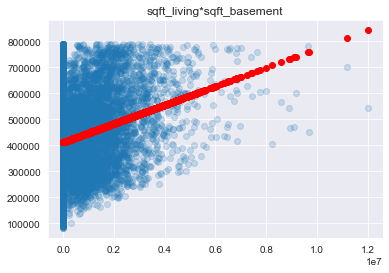

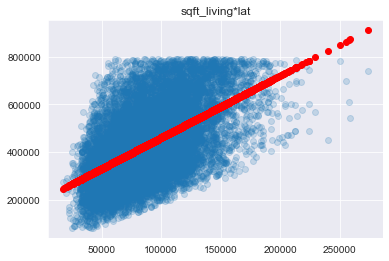

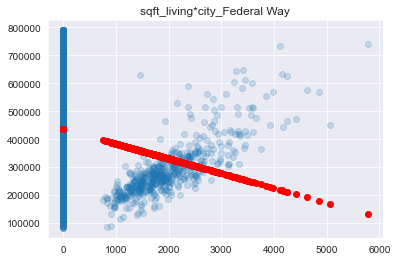

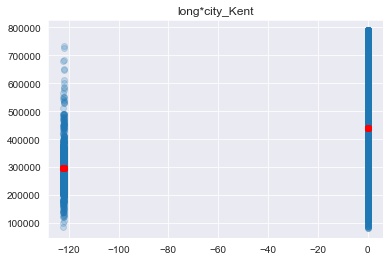

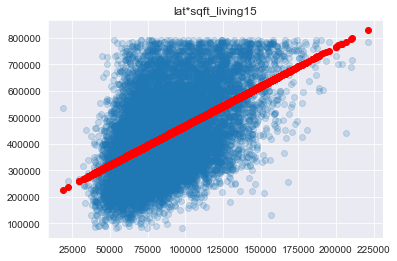

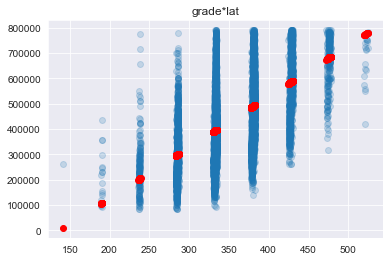

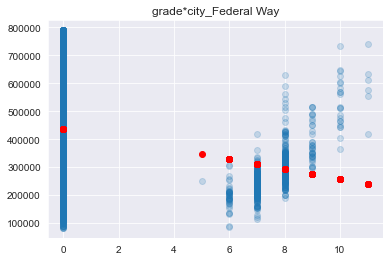

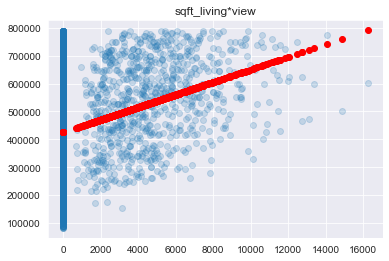

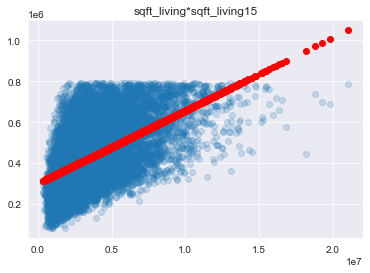

In [43]:
for inter in interactions:
    var = pd.DataFrame(X_train[inter[0]] * X_train[inter[1]])
    linreg = LinearRegression()
    model = linreg.fit(var, y_train)
    y_pred = model.predict(var)
    plt.scatter(var, y_train, alpha=.2)
    plt.scatter(var, y_pred, c='red')
    plt.title('{}*{}'.format(inter[0], inter[1]))
    plt.show()

In [44]:
remove = [('yr_built', 'long'),
          ('yr_built', 'city_Seattle')]
for inter in remove:
    interactions.remove(inter)

In [45]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('grade', 'city_Seattle'),
 ('sqft_living15', 'city_Federal Way'),
 ('sqft_living', 'sqft_basement'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'city_Federal Way'),
 ('long', 'city_Kent'),
 ('lat', 'sqft_living15'),
 ('grade', 'lat'),
 ('grade', 'city_Federal Way'),
 ('sqft_living', 'view'),
 ('sqft_living', 'sqft_living15')]

In [46]:
%run -i "functions/add_interactions.py"

In [47]:
model_int, X_train2, X_test2 = add_interactions(interactions, 
                                             X_train, X_test)

Interaction Added: long * city_Seattle
Current R^2: 0.7181
Current Test MSE: 7398263903.27847
Current MSE Difference: -7398263902.56037

Interaction Added: grade * city_Seattle
Current R^2: 0.7216
Current Test MSE: 7321813995.57335
Current MSE Difference: -7321813994.85175

Interaction Added: sqft_living * sqft_basement
Current R^2: 0.72351
Current Test MSE: 7263370627.24178
Current MSE Difference: -7263370626.51827

Interaction Added: lat * city_Kirkland
Current R^2: 0.72682
Current Test MSE: 7131718589.93686
Current MSE Difference: -7131718589.21004

Interaction Added: sqft_living * lat
Current R^2: 0.73006
Current Test MSE: 7105996373.99863
Current MSE Difference: -7105996373.26857

Interaction Added: grade * city_Federal Way
Current R^2: 0.73079
Current Test MSE: 7086722393.2681
Current MSE Difference: -7086722392.53731

Interaction Added: sqft_living * view
Current R^2: 0.73127
Current Test MSE: 7091308640.64946
Current MSE Difference: -7091308639.91819

Interaction Added: long * 

In [48]:
from sklearn.model_selection import cross_val_score
%run -i "functions/report.py"

In [49]:
X_train2 = sm.add_constant(X_train2)
X_test2 = sm.add_constant(X_test2)

training_model(feat_cols, outcome, y_train, X_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     719.0
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:55:45   Log-Likelihood:            -1.6508e+05
No. Observations:               12958   AIC:                         3.303e+05
Df Residuals:                   12908   BIC:                         3.306e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                            -1.307e+07   3.44e+06     -3.800      0.000   -1.98e+07   -6.33e+06
bedrooms                         -1.159e+04   1125.101    -10.302      0.000   -1.38e+04   -9384.897
bathrooms                         1.894e+04   1859.000     10.188      0.000    1.53e+04    2.26e+04
sqft_living                      -1627.9035    535.803     -3.038      0.002   -2678.156    -577.651
floors                            1.845e+04   2041.078      9.038      0.000    1.44e+04    2.24e+04
waterfront                        8.115e+04   1.79e+04      4.529      0.000     4.6e+04    1.16e+05
view                              3.916e+04   4231.848      9.255      0.000    3.09e+04    4.75e+04
condition                         1.717e+04   1259.317     13.638      0.000    1.47e+04    1.96e+04
grade                             4.148e+04   1519.007     27.308      0.000    3.85e+04    4.45e+04
sqft_basement                       34.3175      7.141      4.806      0.000      20.321      48.315
yr_built                         -1153.2139     42.442    -27.172      0.000   -1236.406   -1070.022
renovated                          826.2430   4715.795      0.175      0.861   -8417.412    1.01e+04
lat                               3.336e+05    2.2e+04     15.160      0.000     2.9e+05    3.77e+05
long                              6148.5613   2.62e+04      0.235      0.814   -4.52e+04    5.75e+04
sqft_living15                    -1040.5968    707.698     -1.470      0.141   -2427.789     346.595
city_Bellevue                     1.198e+05   6225.590     19.240      0.000    1.08e+05    1.32e+05
city_Black Diamond                9.814e+04   1.21e+04      8.084      0.000    7.43e+04    1.22e+05
city_Bothell                     -6.383e+04   9715.311     -6.570      0.000   -8.29e+04   -4.48e+04
city_Carnation                   -3.345e+04    1.4e+04     -2.396      0.017   -6.08e+04   -6088.907
city_Duvall                      -8.786e+04   1.18e+04     -7.446      0.000   -1.11e+05   -6.47e+04
city_Enumclaw                     6.188e+04   9410.168      6.576      0.000    4.34e+04    8.03e+04
city_Fall City                    3.249e+04   1.55e+04      2.093      0.036    2057.264    6.29e+04
city_Federal Way                  1.272e+05   3.73e+04      3.410      0.001    5.41e+04       2e+05
city_Issaquah                     9.637e+04   7717.916     12.487      0.000    8.12e+04    1.12e+05
city_Kenmore                      -7.13e+04   8539.088     -8.349      0.000    -8.8e+04   -5.46e+04
city_Kent                         2.995e+07    6.7e+06      4.469      0.000    1.68e+07    4.31e+07
city_Kirkland                     1.262e+08   8.04e+06     15.694      0.000     1.1e+08    1.42e+08
city_Maple Valley                 1.954e+04   7189.13

In [50]:
model_int = sm.OLS(y_train, X_train2).fit()

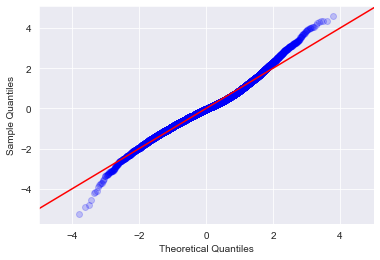

In [51]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_int.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [52]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_int.predict(X_train2)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_int.predict(X_test2)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 82504.87131307248 
 Test RMSE: 84111.85548279253
Percent change:  1.948
Percent change (Base Model vs. Model-Outliers Removed):  -46.723


In [53]:
# Adding interactions decreased RMSE and improved R-squared

### Model: Polynomial Features

In [54]:
%run -i "functions/get_polynomials.py"

Factor bedrooms by 2. R^2: 23837080334.60796


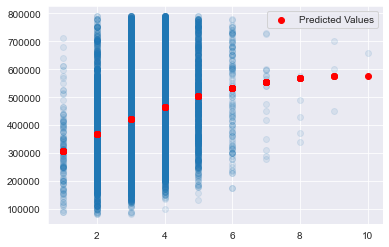

Factor bathrooms by 2. R^2: 21493117517.13909


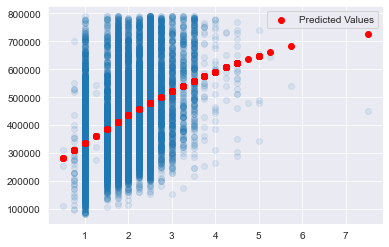

Factor sqft_living by 2. R^2: 18308245908.36213


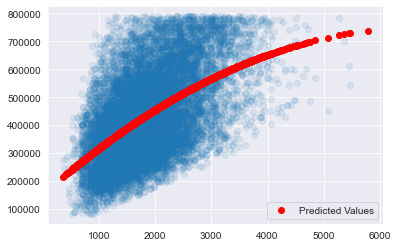

Factor floors by 2. R^2: 23617580764.78374


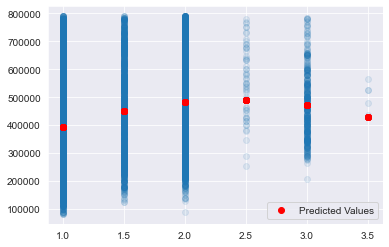

Factor view by 2. R^2: 24607279572.66134


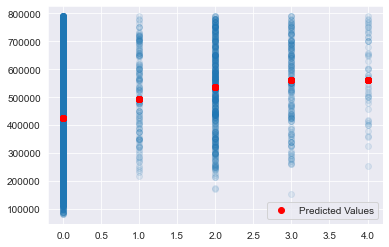

Factor condition by 2. R^2: 25361510683.37368


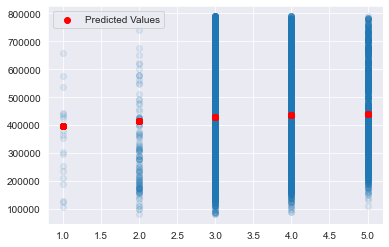

Factor grade by 2. R^2: 17820344420.42375


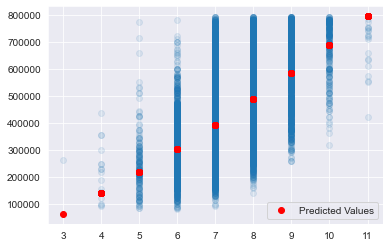

Factor sqft_basement by 2. R^2: 24293696215.86348


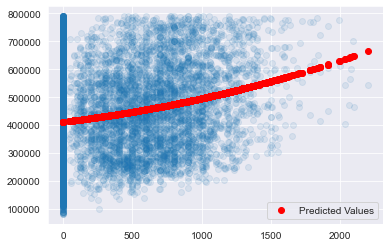

Factor yr_built by 2. R^2: 24394482490.64411


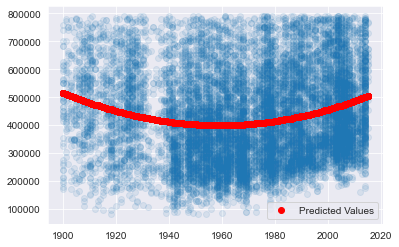

Factor lat by 2. R^2: 19333589905.3609


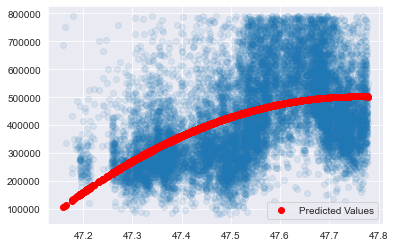

Factor long by 2. R^2: 25204603441.98119


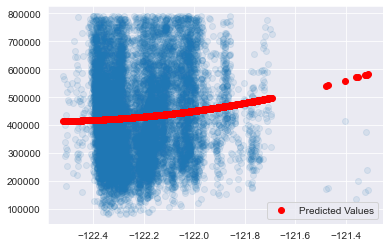

Factor sqft_living15 by 2. R^2: 19549262203.05532


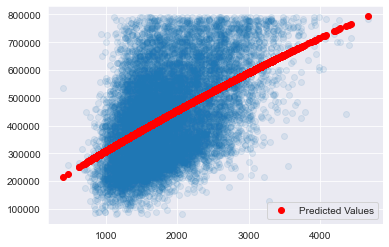

Factor city_Bellevue by 2. R^2: 24527726142.84702


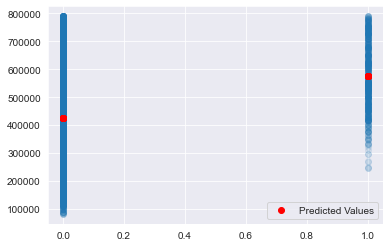

Factor long * city_Seattle by 2. R^2: 24879675962.30379


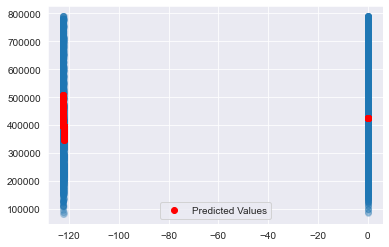

Factor grade * city_Seattle by 2. R^2: 22927348236.94976


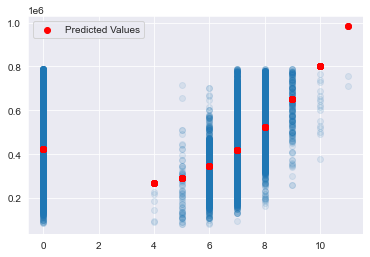

Factor sqft_living * sqft_basement by 2. R^2: 23985728592.07012


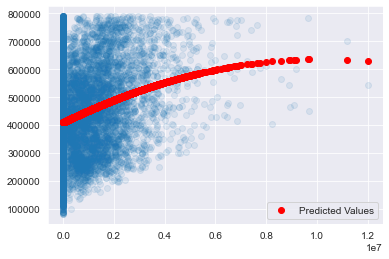

Factor lat * city_Kirkland by 2. R^2: 25050399523.06564


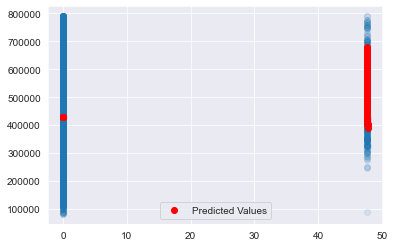

Factor sqft_living * lat by 2. R^2: 18195566916.14998


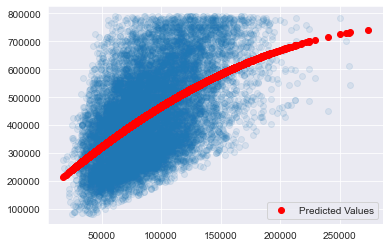

Factor grade * city_Federal Way by 2. R^2: 24224680147.92083


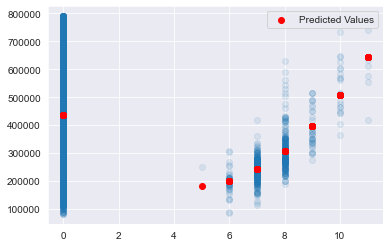

Factor sqft_living * view by 2. R^2: 24463019676.58241


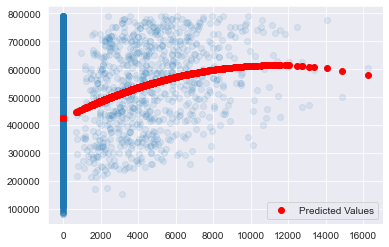

Factor long * city_Kent by 2. R^2: 24127356657.87599


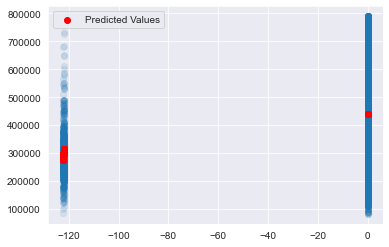

Factor sqft_living * sqft_living15 by 2. R^2: 17923762835.53926


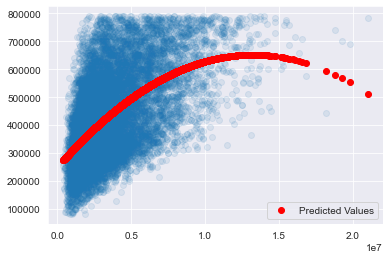

Factor lat * sqft_living15 by 2. R^2: 19425368344.07622


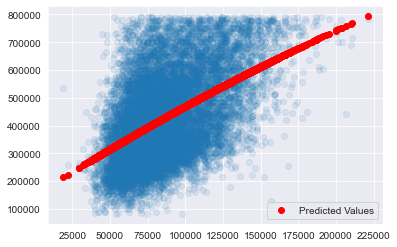

Factor sqft_living * city_Federal Way by 2. R^2: 24328908089.44856


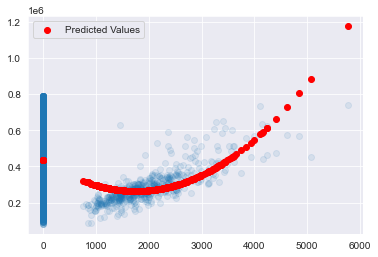

Factor sqft_living15 * city_Federal Way by 2. R^2: 24280970200.51436


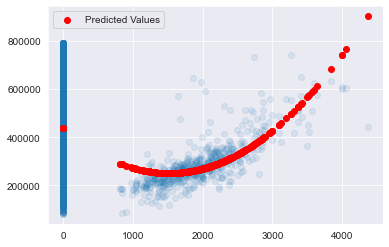

In [55]:
poly_feat = get_polynomial_features(X_train2, 
                                    max_degree = 2)

In [56]:
poly_feat

[('bedrooms', 2),
 ('bathrooms', 2),
 ('sqft_living', 2),
 ('floors', 2),
 ('view', 2),
 ('condition', 2),
 ('grade', 2),
 ('sqft_basement', 2),
 ('yr_built', 2),
 ('lat', 2),
 ('long', 2),
 ('sqft_living15', 2),
 ('city_Bellevue', 2),
 ('long * city_Seattle', 2),
 ('grade * city_Seattle', 2),
 ('sqft_living * sqft_basement', 2),
 ('lat * city_Kirkland', 2),
 ('sqft_living * lat', 2),
 ('grade * city_Federal Way', 2),
 ('sqft_living * view', 2),
 ('long * city_Kent', 2),
 ('sqft_living * sqft_living15', 2),
 ('lat * sqft_living15', 2),
 ('sqft_living * city_Federal Way', 2),
 ('sqft_living15 * city_Federal Way', 2)]

In [57]:
#Perform the same function as PolynomialFeatures, but name
# the columns.
X_train3 = X_train2.loc[:]
X_test3 = X_test2.loc[:]
for feat in poly_feat:
    factor = 2
    while factor <= feat[1]:
        poly_train = X_train2[feat[0]]**factor
        poly_test = X_test2[feat[0]]**factor
        poly_X = X[feat[0]]**factor
        X_train3['{}^{}'.format(feat[0], factor)]=poly_train
        X_test3['{}^{}'.format(feat[0], factor)]=poly_test
        X['{}^{}'.format(feat[0], factor)]=poly_X
        factor +=1

In [58]:
X_train3 = sm.add_constant(X_train3)
X_test3 = sm.add_constant(X_test3)

In [59]:
model_poly = sm.OLS(y_train, X_train3).fit()

In [60]:
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     1063.
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:56:20   Log-Likelihood:            -1.6525e+05
No. Observations:               12958   AIC:                         3.306e+05
Df Residuals:                   12925   BIC:                         3.308e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -9.468e+04   4048.523    -23.387      0.000   -1.03e+05   -8.67e+04
bedrooms                           -8905.3959   4677.431     -1.904      0.057   -1.81e+04     263.059
bathrooms                           2.625e+04   6533.861      4.018      0.000    1.34e+04    3.91e+04
sqft_living                        -1.166e+04   1984.820     -5.872      0.000   -1.55e+04   -7764.562
floors                               4.38e+04   1.05e+04      4.185      0.000    2.33e+04    6.43e+04
waterfront                          7.491e+04   1.98e+04      3.776      0.000     3.6e+04    1.14e+05
view                                2.945e+04   1.19e+04      2.485      0.013    6219.557    5.27e+04
condition                           1.745e+04   1.07e+04      1.627      0.104   -3566.810    3.85e+04
grade                               2.352e+04   1.15e+04      2.037      0.042     888.384    4.61e+04
sqft_basement                         67.4632     13.199      5.111      0.000      41.592      93.334
yr_built                           -4.959e+04   2106.335    -23.541      0.000   -5.37e+04   -4.55e+04
renovated                           9337.8585   5598.854      1.668      0.095   -1636.721    2.03e+04
lat                                  1.62e+05   6806.271     23.795      0.000    1.49e+05    1.75e+05
long                               -4.143e+05   1.74e+04    -23.778      0.000   -4.48e+05    -3.8e+05
sqft_living15                       9623.8438   2990.592      3.218      0.001    3761.841    1.55e+04
city_Bellevue                       4.856e+04   2249.648     21.587      0.000    4.42e+04     5.3e+04
city_Black Diamond                  1.219e+05   1.12e+04     10.894      0.000       1e+05    1.44e+05
city_Bothell                       -1.238e+05   8679.002    -14.263      0.000   -1.41e+05   -1.07e+05
city_Carnation                     -4.043e+04   9223.974     -4.383      0.000   -5.85e+04   -2.23e+04
city_Duvall                        -1.166e+05   8068.073    -14.457      0.000   -1.32e+05   -1.01e+05
city_Enumclaw                       8.832e+04   7756.715     11.386      0.000    7.31e+04    1.04e+05
city_Fall City                      2.982e+04   1.16e+04      2.565      0.010    7031.374    5.26e+04
city_Federal Way                    1.563e+04   3430.673      4.556      0.000    8906.594    2.24e+04
city_Issaquah                       9.188e+04   4676.258     19.648      0.000    8.27e+04    1.01e+05
city_Kenmore                       -1.436e+05   7593.545    -18.909      0.000   -1.58e+05   -1.29e+05
city_Kent                           1700.8306     79.988     21.264      0.000    1544.043    1857.619
city_Kirkland                       -139.7479      5.046    -27.697      0.000    -149.638    -1

In [61]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_poly.predict(X_train3)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_poly.predict(X_test3)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 83616.42084836449 
 Test RMSE: 85093.33815310911
Percent change:  1.766
Percent change (Base Model vs. Model-Outliers Removed):  -46.102


In [62]:
linreg = LinearRegression()
model3 = linreg.fit(X_train3, y_train)

In [63]:
report(model3, X_train3, X_test3, 
       save_as='figures/Model_PolyResids.png')

************
High Impact Variables:

Variable: yr_built
Coefficient: -78860.89701054267

Variable: city_Duvall
Coefficient: -92613.20117213082

Variable: city_Issaquah
Coefficient: 93490.07438312855

Variable: city_Kenmore
Coefficient: -68620.5671207673

Variable: city_Medina
Coefficient: 398882.20425543096

Variable: city_Mercer Island
Coefficient: 234926.4402704969

Variable: long * city_Seattle
Coefficient: 592551.1711301197

Variable: long * city_Kent
Coefficient: -206748.49699348255

************
************
Low Impact Variables:

Variable: sqft_living * sqft_living15
Coefficient: -0.00543451988050947

Variable: sqft_living * sqft_basement^2
Coefficient: 1.3405951904132962e-09

Variable: sqft_living * lat^2
Coefficient: -0.00020645121276174905

Variable: sqft_living * view^2
Coefficient: -0.000624073356448207

Variable: sqft_living * sqft_living15^2
Coefficient: -1.800799509510398e-10

Variable: lat * sqft_living15^2
Coefficient: 0.00012368200623313896

Variable: sqft_living * ci

NameError: name 'mean_squared_error' is not defined

### P-Value Filter

In [64]:
%run -i "functions/stepwise.py"

In [65]:
results = stepwise_selection(X_train3, y_train)
X_train4 = X_train3.loc[:,results]
X_test4 = X_test3.loc[:,results]
X = X.loc[:,results]

/Users/stephenenke/Documents/DSC-Project-2/Seattle-Housing-Regression-Analysis/functions/stepwise.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  const                          with p-value 0.0
Add  grade                          with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_living * lat^2            with p-value 0.0
Add  lat^2                          with p-value 0.0
Add  yr_built                       with p-value 2.26413e-189
Add  sqft_living * lat              with p-value 2.65071e-108
Add  yr_built^2                     with p-value 1.5152e-96
Add  city_Bellevue                  with p-value 7.45111e-134
Add  city_Bellevue^2                with p-value 7.45111e-134
Add  view                           with p-value 1.56669e-100
Add  city_Mercer Island             with p-value 1.40164e-68
Add  city_Issaquah                  with p-value 2.50384e-68
Add  condition                      with p-value 5.66846e-57
Add  city_Sammamish                 with p-value 5.73344e-58
Add  city_Redmond                   with p-value 7.43007e-61
Add  grade * city_Seattle^2         with p-value 1.01053e-47

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [66]:
model_poly_step = sm.OLS(y_train, X_train4).fit()
model_poly_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     931.0
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:04:00   Log-Likelihood:            -1.6458e+05
No. Observations:               12958   AIC:                         3.292e+05
Df Residuals:                   12915   BIC:                         3.296e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -8.906e+05   3.34e+04    -26.671      0.000   -9.56e+05   -8.25e+05
lat                                 1.529e+08    5.6e+06     27.294      0.000    1.42e+08    1.64e+08
sqft_living * lat^2                   -0.0005   7.77e-05     -6.439      0.000      -0.001      -0.000
lat^2                              -1.605e+06   5.89e+04    -27.264      0.000   -1.72e+06   -1.49e+06
yr_built                           -6.708e+04   3536.512    -18.968      0.000    -7.4e+04   -6.01e+04
sqft_living * lat                    250.8622     32.686      7.675      0.000     186.793     314.931
yr_built^2                            16.8789      0.902     18.711      0.000      15.111      18.647
city_Bellevue                       1.476e+04   2292.119      6.441      0.000    1.03e+04    1.93e+04
city_Bellevue^2                     1.479e+04   2291.708      6.454      0.000    1.03e+04    1.93e+04
view                                3.808e+04   4046.192      9.412      0.000    3.02e+04     4.6e+04
city_Mercer Island                  1.192e+05   1.21e+04      9.881      0.000    9.56e+04    1.43e+05
city_Issaquah                       1.379e+04   4566.487      3.021      0.003    4842.381    2.27e+04
condition                           2.126e+04   1211.558     17.547      0.000    1.89e+04    2.36e+04
lat * sqft_living15                    1.2893      0.111     11.593      0.000       1.071       1.507
city_Kirkland                       9.808e+04   6793.716     14.437      0.000    8.48e+04    1.11e+05
lat * city_Kirkland                 2.343e+06   1.62e+05     14.465      0.000    2.03e+06    2.66e+06
lat * city_Kirkland^2              -4.918e+04   3398.282    -14.471      0.000   -5.58e+04   -4.25e+04
city_Black Diamond                  1.065e+05   1.04e+04     10.211      0.000    8.61e+04    1.27e+05
city_Enumclaw                       1.926e+05   9374.493     20.549      0.000    1.74e+05    2.11e+05
city_Duvall                         -1.34e+05   7876.000    -17.020      0.000   -1.49e+05   -1.19e+05
sqft_basement^2                       -0.0198      0.002     -9.486      0.000      -0.024      -0.016
city_Kenmore                       -1.382e+05   6893.695    -20.047      0.000   -1.52e+05   -1.25e+05
bedrooms                           -8430.9193   1093.583     -7.709      0.000   -1.06e+04   -6287.335
bathrooms                           1.108e+04   1767.397      6.271      0.000    7618.917    1.45e+04
sqft_living                         -1.18e+04   1553.363     -7.599      0.000   -1.48e+04   -8759.550
long^2                              2.407e+05   9021.190     26.677      0.000    2.23e+05    2.58e+05
long                                5.865e+07    2.2e+06     26.711      0.000    5.43e+07     6

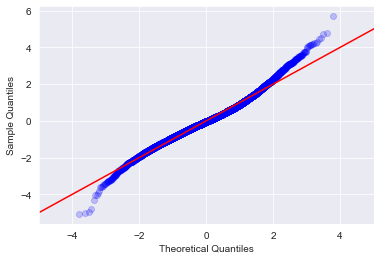

In [70]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_poly_step.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [69]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_poly_step.predict(X_train4)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_poly_step.predict(X_test4)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 79389.27152710747 
 Test RMSE: 80356.90855298635
Percent change:  1.219
Percent change (Base Model vs. Model-Outliers Removed):  -49.102


In [68]:
linreg = LinearRegression()
model4 = linreg.fit(X_train4, y_train)
report(model4, X_train4, X_test4, 
       save_as = 'figures/Model4Resids.png')

************
High Impact Variables:

Variable: lat
Coefficient: 154158158.66149995

Variable: lat^2
Coefficient: -1618247.5957374976

Variable: lat * city_Kirkland
Coefficient: 2322388.2641860005

Variable: city_Kenmore
Coefficient: -134726.52241603663

Variable: long
Coefficient: 5767728.255458135

Variable: long * city_Kent
Coefficient: -434241.7276175531

************
************
Low Impact Variables:

Variable: sqft_living * lat^2
Coefficient: -0.0004775511949303285

Variable: sqft_living15 * city_Federal Way^2
Coefficient: -0.00644727423787117

Variable: sqft_living * sqft_living15
Coefficient: -0.009524144232273102

************


NameError: name 'mean_squared_error' is not defined

In [82]:
house_data_2std = house_data[house_data['price'] <= 790000]

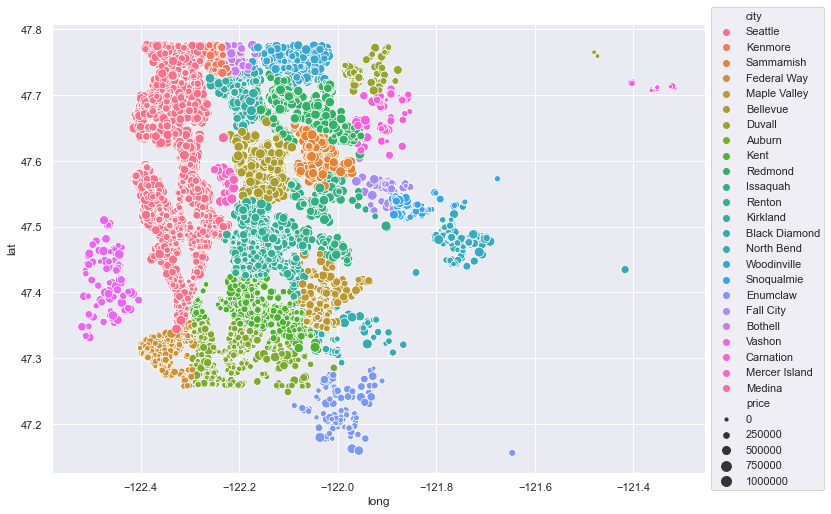

In [86]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.scatterplot(house_data_2std.long, house_data_2std.lat, hue=house_data_2std.city, size=house_data_2std.price,
    sizes=(10, 100))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fancybox=True);

In [71]:
house_data['city']

0          Seattle
1          Seattle
2          Kenmore
3          Seattle
4        Sammamish
           ...    
21592      Seattle
21593      Seattle
21594      Seattle
21595     Issaquah
21596      Seattle
Name: city, Length: 21597, dtype: object

In [ ]:
# Our Real Estate focus is on houses $790,000 and under
# We can use the model to predict locations within the customer's price range
# If they are focused on an expensive area, we can help find adjacent cities to give them access nearby

In [ ]:
# As latitude increases (we move further north), prices increase generally

In [ ]:
# Kent, Kenmore, and Kirkland... that's unfortunate string of names